In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyfonts import set_default_font, load_bunny_font
import matplotlib.patheffects as path_effects

In [2]:
schedule = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2026/2026-02-10/schedule.csv")

In [3]:
schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1866 entries, 0 to 1865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  1866 non-null   object
 1   discipline_code       1866 non-null   object
 2   discipline_name       1866 non-null   object
 3   event_code            1866 non-null   object
 4   event_description     1866 non-null   object
 5   start_datetime_local  1866 non-null   object
 6   end_datetime_local    1866 non-null   object
 7   start_datetime_utc    1866 non-null   object
 8   end_datetime_utc      1866 non-null   object
 9   is_medal_event        1866 non-null   bool  
 10  is_training           1866 non-null   bool  
 11  venue_code            1803 non-null   object
 12  venue_name            1803 non-null   object
 13  venue_slug            1803 non-null   object
 14  location_name         1866 non-null   object
 15  location_code         1866 non-null   

In [4]:
schedule.head(2)

,date,discipline_code,discipline_name,event_code,event_description,start_datetime_local,end_datetime_local,start_datetime_utc,end_datetime_utc,is_medal_event,...,venue_code,venue_name,venue_slug,location_name,location_code,session_code,estimated_start,day_of_week,start_time,end_time
0,2026-02-04,ALP,Alpine Skiing,ALPMDH----------------TRNO000100--,Men's Downhill 1st Official Training,2026-02-04T11:30:00Z,2026-02-04T13:30:00Z,2026-02-04T10:30:00Z,2026-02-04T12:30:00Z,False,...,SSC,Stelvio Ski Centre,stelvio-ski-centre,Stelvio Ski Centre-ALP Course,SAL,OALPTA,False,Wednesday,11:30:00,13:30:00
1,2026-02-04,ALP,Alpine Skiing,ALPMDH----------------TRNO000200--,Men's Downhill 2nd Official Training,2026-02-05T11:30:00Z,2026-02-05T13:30:00Z,2026-02-05T10:30:00Z,2026-02-05T12:30:00Z,False,...,SSC,Stelvio Ski Centre,stelvio-ski-centre,Stelvio Ski Centre-ALP Course,SAL,OALPTC,False,Wednesday,11:30:00,13:30:00


In [5]:
# Convert columns to datetime
schedule["start_time"] = pd.to_datetime(schedule["start_time"], format="%H:%M:%S")
schedule["end_time"] = pd.to_datetime(schedule["end_time"], format="%H:%M:%S")

# Calculate time delta in minutes
schedule["td_mins"] = schedule["end_time"].dt.to_period("min") - schedule["start_time"].dt.to_period("min")
schedule["minutes"] = schedule["td_mins"] / pd.Timedelta(minutes=1)

In [6]:
# Function to group sports
def categorize(discipline):
    if discipline in ["Bobsleigh", "Luge", "Skeleton"]:
        return "sliding"
    elif discipline in ["Curling", "Figure Skating", "Ice Hockey", "Short Track Speed Skating", "Speed Skating"]:
        return "ice sports"
    else:
        return "snow sports"

# Apply function 
schedule["group"] = schedule["discipline_name"].apply(categorize)

In [7]:
# Convert date to datetime
schedule["date"] = pd.to_datetime(schedule["date"])

# Extract the day of the year
schedule["day_of_year"] = schedule["date"].dt.dayofyear

In [8]:
# Total event count per group
total = schedule["group"].value_counts().reset_index(name="total")
# Filter for medal events
medals = schedule[schedule["is_medal_event"]==True]
# Medal event count per group
medal = medals["group"].value_counts().reset_index(name="medal")
# Merge total and medal event counts
titles = pd.merge(total, medal, on="group")

In [9]:
# Merge schedule and titles dfs
df = pd.merge(schedule, titles, on="group")

In [10]:
# Load custom fonts
font_title = load_bunny_font("Poppins")
font = load_bunny_font("Roboto Condensed")
set_default_font(font)

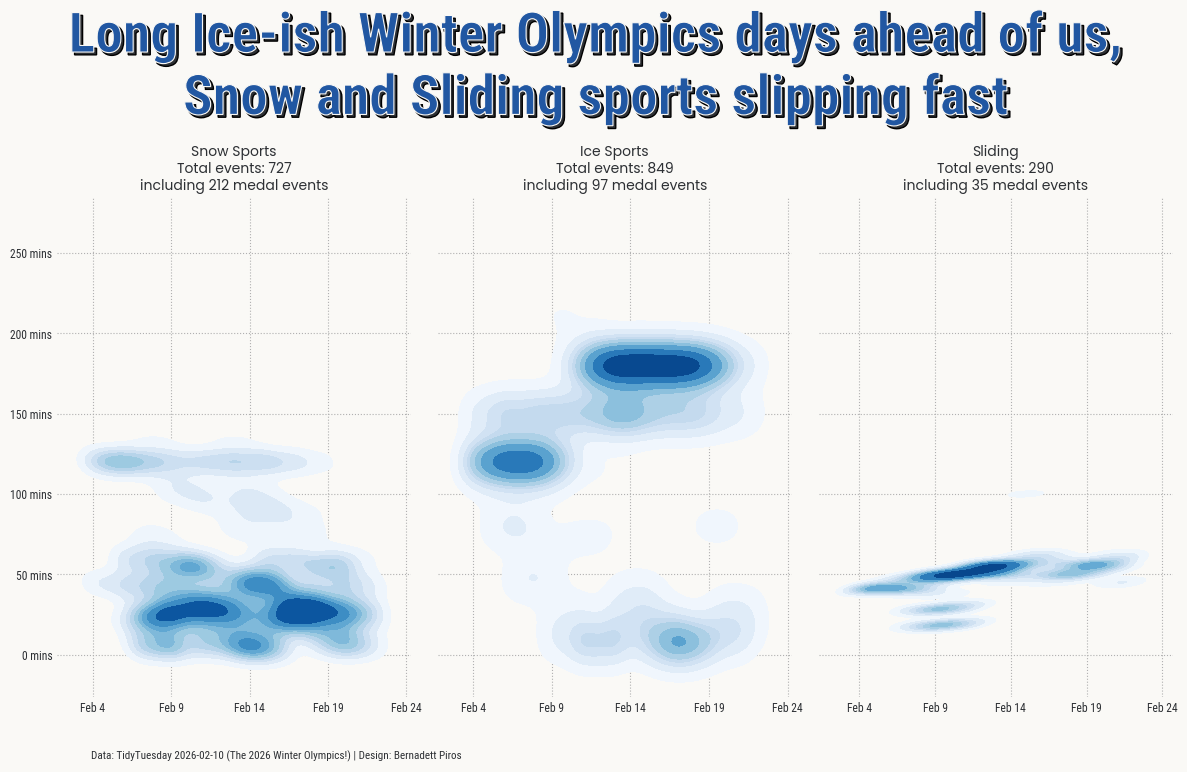

In [11]:
# Unique groups
groups = df["group"].unique()

# Create subplotsper group
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6), sharey=True)

# Loop over each group and create KDE plot 
for i, group in enumerate(groups):
    ax = axes[i]
    
    # Filter the data for the current group
    group_data = df[df["group"] == group]
    
    # Create the KDE plot for the current group
    sns.kdeplot(x=group_data["day_of_year"], y=group_data["minutes"], cmap="Blues", fill=True, bw_adjust=0.5, ax=ax, zorder=3)

    # Extract count1 and count2 for the current group
    total = group_data["total"].iloc[0]
    medal = group_data["medal"].iloc[0]
    
    # Subplot title 
    ax.set_title(f'{group.title()}\nTotal events: {total}\nincluding {medal} medal events', color="#2D3034", font=font_title) #2157a2

    # Remove axis labels
    ax.set(xlabel=None)
    ax.set(ylabel=None)

    # Add grid and remove the spines
    ax.grid(ls="dotted", zorder=-3)
    ax.spines[["top", "bottom", "right", "left"]].set_visible(False)

    # Format x tick labels
    locationx = [35, 40, 45, 50, 55]    
    labelsx = ["Feb 4", "Feb 9", "Feb 14", "Feb 19", "Feb 24"]    
    ax.set_xticks(locationx, labels=labelsx)

    # Format y tick labels
    locationy = [0, 50, 100, 150, 200, 250]    
    labelsy = ["0 mins", "50 mins", "100 mins", "150 mins", "200 mins", "250 mins"]    
    ax.set_yticks(locationy, labels=labelsy)

    # Remove tick lines and format tick labels
    ax.tick_params(length=0, labelcolor="#2D3034", labelsize="small")

    # Axes background color
    ax.set_facecolor("#FAF9F6")

# Figure background color
fig.set_facecolor("#FAF9F6") 

# Title
t=fig.text(0.5, 1.025, "Long Ice-ish Winter Olympics days ahead of us,\nSnow and Sliding sports slipping fast", color="#2157a2", size=40, weight="bold", ha="center")

t.set_path_effects([
    path_effects.PathPatchEffect(
        offset=(2, -2), facecolor="#2D3034"),
    path_effects.PathPatchEffect( 
        edgecolor="#FAF9F6", linewidth=0.8, facecolor="#2157a2")])

# Adjust the layout 
plt.tight_layout()

# Add caption
fig.text(0.08, -0.05, "Data: TidyTuesday 2026-02-10 (The 2026 Winter Olympics!) | Design: Bernadett Piros", size=8, color="#2D3034")

plt.show()

# Save figure
#fig.savefig("2026-02-10.png", bbox_inches="tight", pad_inches=0.2)